# Chi-Square Test for Age-[O/Fe] of Multi-Zone Outputs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from multizone_stars import MultizoneStars
from apogee_tools import import_apogee, apogee_region, apogee_mdf
from age_ofe import plot_astroNN_medians, plot_vice_medians
from score_multizone_outputs import score_age_ofe
import paths
import _globals
from utils import get_bin_centers

In [2]:
apogee_data = import_apogee()
mzs1 = MultizoneStars.from_output('gaussian/insideout/plateau_width10/diskmodel')
mzs2 = MultizoneStars.from_output('gaussian/insideout/prompt/diskmodel')
mzs3 = MultizoneStars.from_output('gaussian/earlyburst/plateau_width10/diskmodel')

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
0.2732521569868833

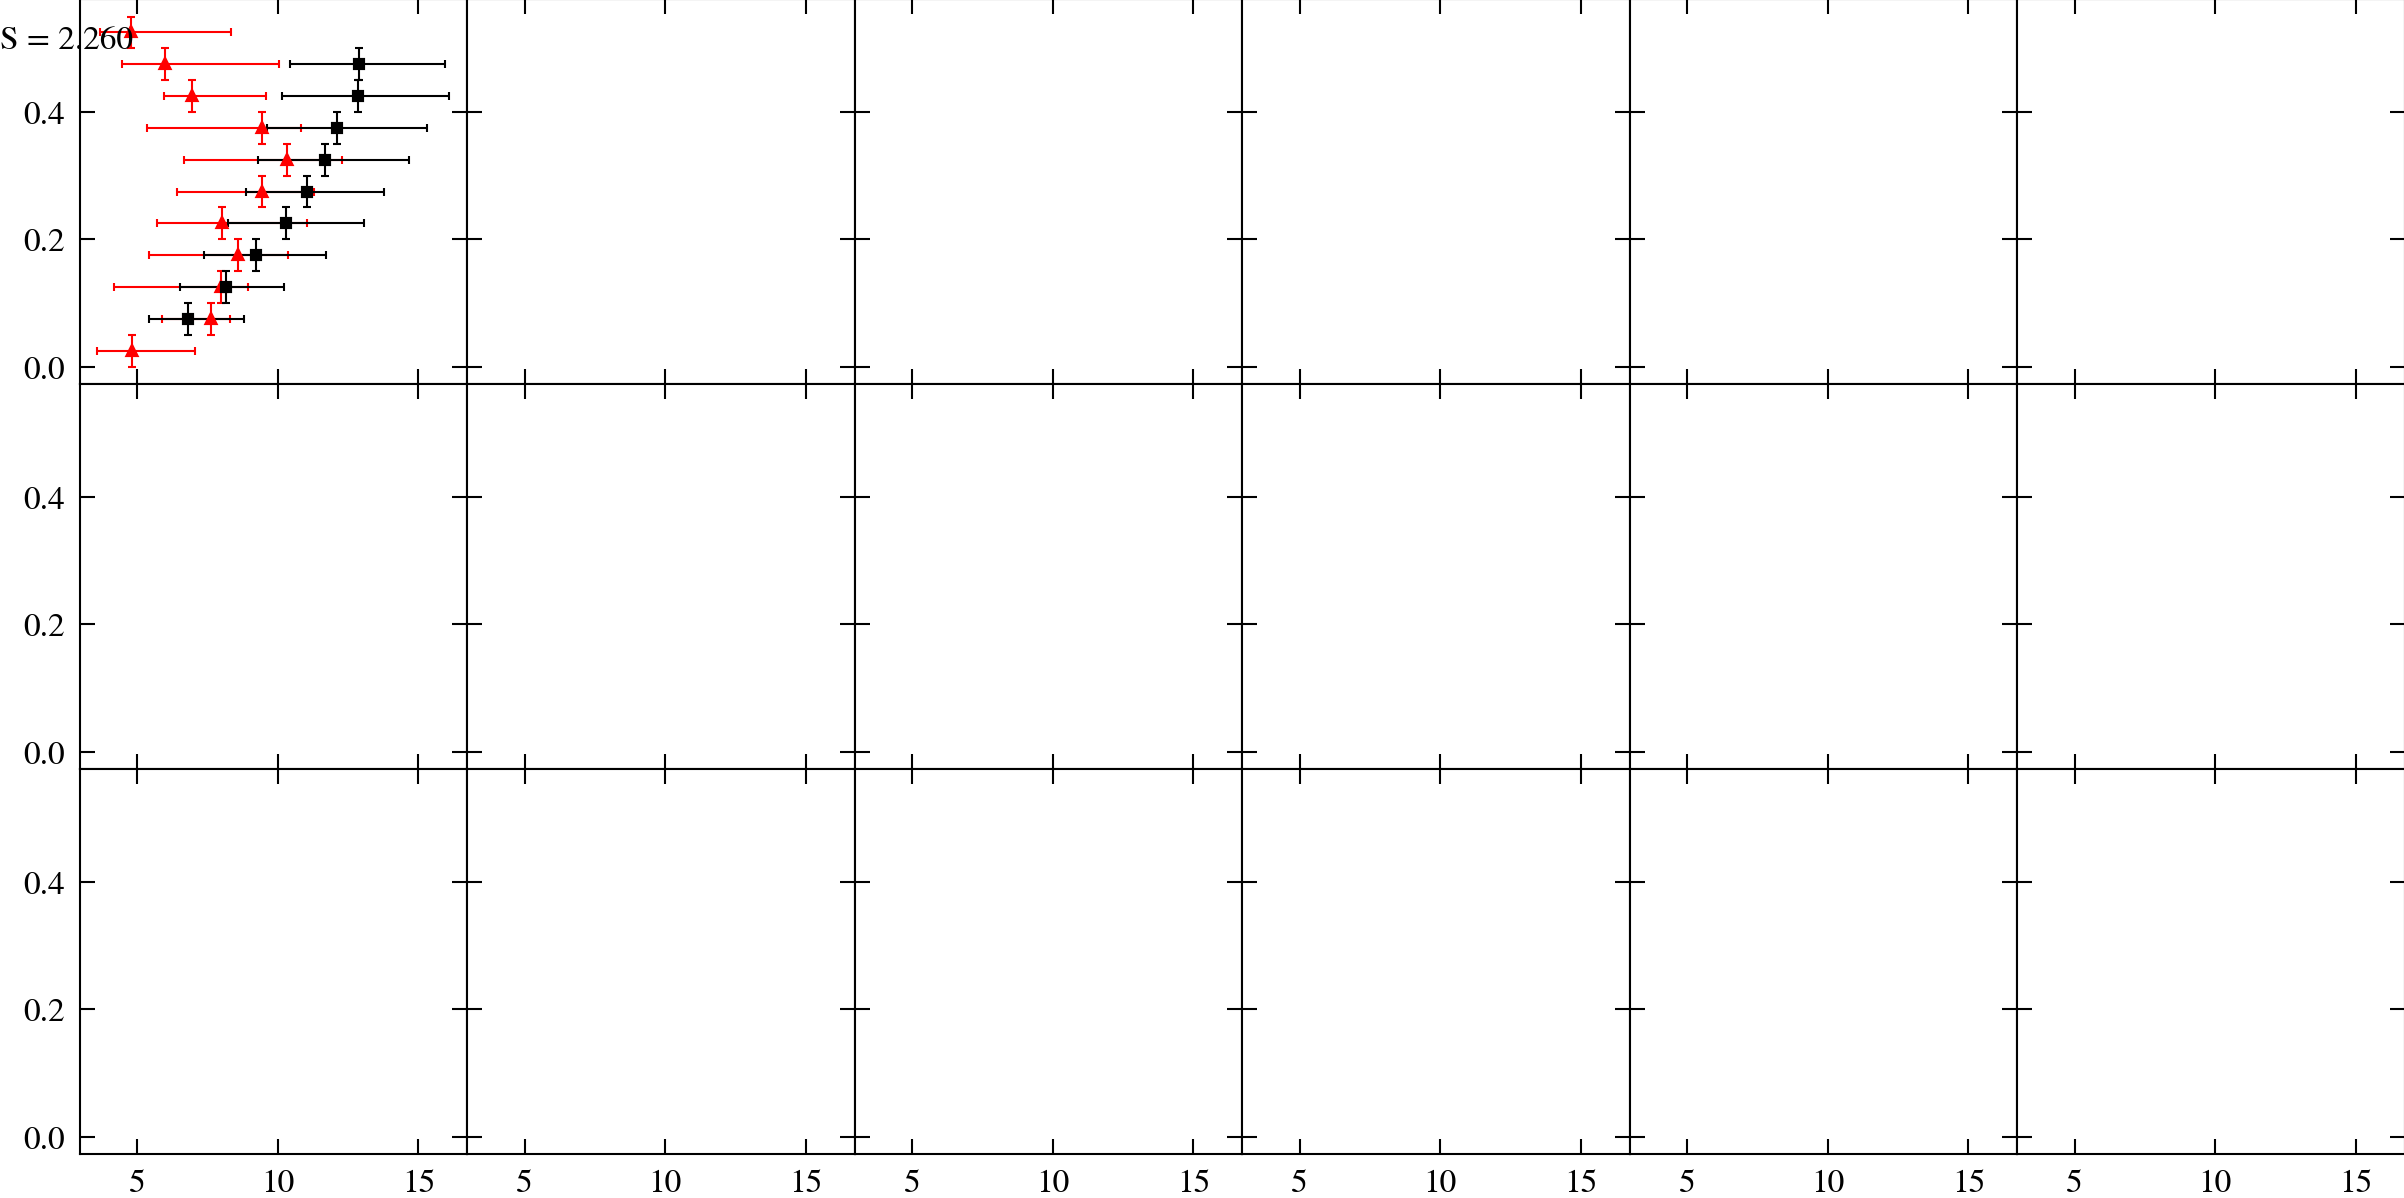

In [10]:
fig, axs = plt.subplots(len(_globals.ABSZ_BINS)-1, len(_globals.GALR_BINS)-1,
                        figsize=(10, 5), sharex=True, sharey=True)
plt.style.use(paths.styles / 'paper.mplstyle')
fig.subplots_adjust(wspace=0., hspace=0.)
xrange = (-0.15, 0.6)
stats = []
weights = []
pvals = []
for i, row in enumerate(axs):
    absz_lim = (_globals.ABSZ_BINS[-(i+2)], _globals.ABSZ_BINS[-(i+1)])
    for j, ax in enumerate(row):
        galr_lim = (_globals.GALR_BINS[j], _globals.GALR_BINS[j+1])
        # APOGEE DF
        apogee_subset = apogee_region(apogee_data, galr_lim, absz_lim)
        apogee_medians = plot_astroNN_medians(axs[i,j], apogee_subset, age_col='LATENT_AGE', 
                             label='L23', plot_low_count_bins=False)
        # VICE DF
        vice_subset = mzs1.model_uncertainty(apogee_data).region(galr_lim, absz_lim)
        vice_medians = plot_vice_medians(axs[i,j], vice_subset.stars, label='Model',
                          plot_low_mass_bins=False)
        # Old scores
        old_score = score_age_ofe(vice_subset, apogee_subset)
        ax.text(0.13, 0.5, f'S = {old_score:.3f}')
        # Chi-square
        df = pd.DataFrame({'APOGEE': apogee_medians[0], 'VICE': vice_medians[0]})
        df.dropna(how='any', inplace=True)
        x2 = chisquare(df['APOGEE'], df['VICE'])
        ax.text(0.13, 0.42, r'$\chi^2=%s$' % x2.statistic)
        ax.text(0.13, 0.35, f'p = {x2.pvalue}')
axs[0,0].set_xscale('log')
for i, ax in enumerate(axs[0,:]):
    ax.set_title(r'$%s\leq R_{\rm{Gal}} < %s$ kpc' % (_globals.GALR_BINS[i], _globals.GALR_BINS[i+1]))
for ax in axs[-1,:]:
    ax.set_xlabel('Age [Gyr]')
for i, ax in enumerate(axs[:,0]):
    absz_lim = (_globals.ABSZ_BINS[-(i+2)], _globals.ABSZ_BINS[-(i+1)])
    ax.set_ylabel(str(r'$%s\leq |z| < %s$ kpc' % absz_lim) + '\n[O/Fe]')
plt.show()